## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [40]:
import string
import os

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [3]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [41]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here

text = ''.join(text).lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


In [ ]:
# !pip install requests



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\pavel\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [12]:
import requests


url = 'https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt'

try:
    response = requests.get(url)
    response.raise_for_status()  

    with open('onegin.txt', 'w', encoding='utf-8') as file:
        file.write(response.text)

except requests.exceptions.HTTPError as http_err:
    print(f"HTTP error occurred: {http_err}") 
except Exception as err:
    print(f"An error occurred: {err}")


File downloaded successfully as 'onegin.txt'.


### Data loading: "Евгений Онегин"


In [42]:
# !wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
# with open('onegin.txt', 'r') as iofile:
#     text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [43]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = ''.join(text).lower()

Put all the characters, that you've seen in the text, into variable `tokens`.

In [20]:
# tokens = sorted(set(out))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [44]:
# dict <index>:<char>
# Your great code here

# dict <char>:<index>
# Your great code here

tokens = sorted(set(text))

idx_to_token = {i: ch for i, ch in enumerate(tokens)}
token_to_idx = {ch: i for i, ch in enumerate(tokens)}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [45]:
# Your code here

import numpy as np

loss_history = []

hidden_size = 128
seq_length = 50    
learning_rate = 1e-1

data = text
data_size = len(data)
vocab_size = len(tokens)

print((data_size, vocab_size))

def char_to_ix(ch):
    return token_to_idx[ch]

def ix_to_char(ix):
    return idx_to_token[ix]


Wxh = np.random.randn(hidden_size, vocab_size)*0.01  
Whh = np.random.randn(hidden_size, hidden_size)*0.01  
Why = np.random.randn(vocab_size, hidden_size)*0.01  
bh = np.zeros((hidden_size, 1))  
by = np.zeros((vocab_size, 1))  

def lossFun(inputs, targets, hprev):

    xs, hs, ys, ps = {}, {}, {}, {}
    hs[-1] = np.copy(hprev)

    for t in range(len(inputs)):
        xs[t] = np.zeros((vocab_size,1))  
        xs[t][inputs[t]] = 1
        hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh)
        ys[t] = np.dot(Why, hs[t]) + by
        ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t]))
    

    loss = 0
    for t in range(len(inputs)):
        loss += -np.log(ps[t][targets[t],0])
    
    dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
    dbh, dby = np.zeros_like(bh), np.zeros_like(by)
    dhnext = np.zeros_like(hs[0])
    for t in reversed(range(len(inputs))):
        dy = np.copy(ps[t])
        dy[targets[t]] -= 1
        dWhy += np.dot(dy, hs[t].T)
        dby += dy
        dh = np.dot(Why.T, dy) + dhnext
        dhraw = (1 - hs[t]*hs[t]) * dh
        dbh += dhraw
        dWxh += np.dot(dhraw, xs[t].T)
        dWhh += np.dot(dhraw, hs[t-1].T)
        dhnext = np.dot(Whh, dhraw)
    for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
        np.clip(dparam, -5, 5, out=dparam)  
    
    return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs)-1]

def sample(h, seed_ix, n):

    x = np.zeros((vocab_size,1))
    x[seed_ix] = 1
    ixes = []
    for t in range(n):
        h = np.tanh(np.dot(Wxh, x) + np.dot(Whh, h) + bh)
        y = np.dot(Why, h) + by
        p = np.exp(y) / np.sum(np.exp(y))
        ix = np.random.choice(range(vocab_size), p=p.ravel())
        x = np.zeros((vocab_size,1))
        x[ix] = 1
        ixes.append(ix)
    return ixes

n, p = 0, 0
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by)
smooth_loss = -np.log(1.0/vocab_size)*seq_length 

max_iterations = 10000 

while n < max_iterations:

    if p+seq_length+1 >= len(data) or n == 0:
        hprev = np.zeros((hidden_size,1))
        p = 0 
    inputs = [char_to_ix(ch) for ch in data[p:p+seq_length]]
    targets = [char_to_ix(ch) for ch in data[p+1:p+seq_length+1]]

    loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)
    smooth_loss = smooth_loss * 0.999 + loss * 0.001

    if n % 1000 == 0:
        print('iter %d, loss: %f' % (n, smooth_loss))
        loss_history.append(loss)
        sample_ix = sample(hprev, inputs[0], 200)
        txt = ''.join(ix_to_char(ix) for ix in sample_ix)
        print('----\n %s \n----' % (txt, ))

    for param, dparam, mem in zip([Wxh, Whh, Why, bh, by],
                                  [dWxh,dWhh,dWhy,dbh,dby],
                                  [mWxh,mWhh,mWhy,mbh,mby]):
        mem += dparam * dparam
        param += -learning_rate * dparam / (np.sqrt(mem)+1e-8)

    p += seq_length
    n += 1

hprev = np.zeros((hidden_size,1))
seed_ix = char_to_ix('t')
sample_ix = sample(hprev, seed_ix, 500)
generated_text = ''.join(ix_to_char(ix) for ix in sample_ix)
print("щoutput:\n", generated_text)

(100225, 38)
iter 0, loss: 181.879305
----
 ib?yi-
iz.o'r 'wo(dgcgb,m:o)bm,du(f!(.,g!?hdev)
g?:,oraam..nlj'ibk:p':x,xpjw,.nlzxghfs;vri  dcluq;?w:ss.jnlak:(,?vr?krjamgcwn!?b;
gyjgx
e ,u'i)rkavms!
lx)zs-?qfjl(mw)c.ktc(e'gc
mzwv?vlfk;rnfq,mdmdy,f' 
----
iter 1000, loss: 164.638833
----
 e n sh ekeeth  y ,mtoro.
 mo bewhuisc  me not nwhek l yolhh  mo itebanw
woo m
 mo ech namhhothewinal as-oi h ledeiyoptw n,
y moyo tnl fador mily  v t ywo  hgy mov
i wthoy tktll
 kirh
e  pilty womnoto; 
----
iter 2000, loss: 144.652439
----
 rrill ichy
 dy d be  hanshe norympbdn gknaandar, lot i baminghar uighed haikery d

 hy mlnl;
  de greghmiryh s d dabe dorr t  sshinerethcy cgy l w dhy d  ;

  ros .
 uy ff reall'mnauinght utakd gh win 
----
iter 3000, loss: 129.939869
----
 woss gowi ysthe  alieth iapnh deme whisg,
 illan my myos woutwad menos, an tut thuinnth,
 althilh mapasd tisd,
 ly at th mhramy.
  wodeanithysas worgtenegy meraw ahout want st ky bi mlpw whe.
e biil
  
----
iter 4000, loss: 121.91861

In [34]:
generated_text[:500]

"  fak miv the leas dyill weath myth ores thio not rran my the ard;\n   plitixk\n\n\n  ais\n    fould my dive whyullins of frowit.\n\n   cotfaim wirg wapdle-t maing, do is all;\n  allllige wey wit ollis jveand\n  loving wireade tachith hainte f aull norendee fea\n  aspistraf'taugyte?\n  ho\n\n  po srant,\n  bovh thavy thorle olltauos'd hadthin-m'd at of ery a note!\n  fove on bosin hou iigh gow, andell ofat-le luid faven no! thaicwit ulsisprgan codst\n\n   felor'de,\n  do fof i of thoalld,\n  favearad,\n  nas\n\n t ei"

Plot the loss function (axis X: number of epochs, axis Y: loss function).

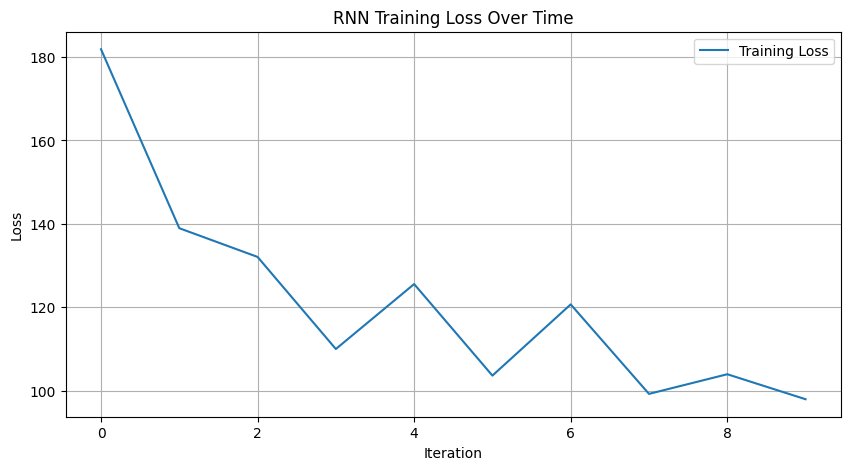

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('RNN Training Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
# def generate_sample(char_rnn, seed_phrase=' Hello', max_length=500, temperature=1.0):
#     '''
#     ### Disclaimer: this is an example function for text generation.
#     ### You can either adapt it in your code or create your own function
    
#     The function generates text given a phrase of length at least SEQ_LENGTH.
#     :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
#     :param max_length: maximum output length, including seed_phrase
#     :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
#         smaller temperature converges to the single most likely output.
        
#     Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
#     of the next symbol.
#     '''
    
#     x_sequence = [token_to_id[token] for token in seed_phrase]
#     x_sequence = torch.tensor([[x_sequence]], dtype=torch.int64)
#     hid_state = char_rnn.initial_state(batch_size=1)
    
#     #feed the seed phrase, if any
#     for i in range(len(seed_phrase) - 1):
#         print(x_sequence[:, -1].shape, hid_state.shape)
#         out, hid_state = char_rnn(x_sequence[:, i], hid_state)
    
#     #start generating
#     for _ in range(max_length - len(seed_phrase)):
#         print(x_sequence.shape, x_sequence, hid_state.shape)
#         out, hid_state = char_rnn(x_sequence[:, -1], hid_state)
#         # Be really careful here with the model output
#         p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]
        
#         # sample next token and push it back into x_sequence
#         print(p_next.shape, len(tokens))
#         next_ix = np.random.choice(len(tokens), p=p_next)
#         next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
#         print(x_sequence.shape, next_ix.shape)
#         x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
#     return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [35]:
# An example of generated text.
# print(generate_text(length=500, temperature=0.2))

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [46]:
# Your beautiful code here

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [47]:
# Text generation with different temperature values here

Epoch [5/5] Loss: 1.9123


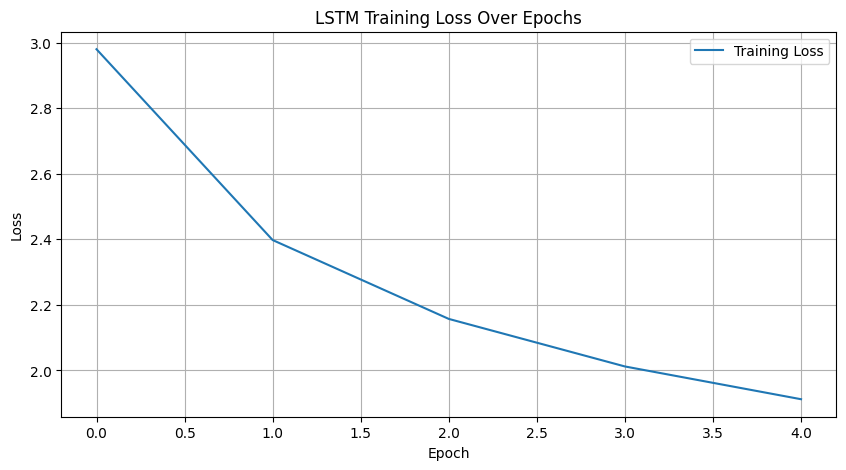

Temperature = 0.1
shall i compare thee to and the seart in the sore the seart the searter so the sore the seart in the sears seart,
     the seart the seare the seart in the sees the seart so sees the seart in the seart,
  and the seart the seart in the seart in the seart in the seart in the seart the seart in the se
------------------------------------------------------------
Temperature = 0.2
shall i compare thee to all the sull my searter with bear doth the my sees the shest and the prove stour the the sear the seart the sees the sees in the seen thee the the sill the sears in the are the merest the sor the sell in the seart,
  and the whis the seart;
  and the seart the seart,
  and th
------------------------------------------------------------
Temperature = 0.5
shall i compare thee to as love the sees in my herst all ware the read thee,
     ars that dost couch what in minest anders be bears seaed,
  when sund lece thou sull dot sear'd owe;
  the pries in my love i they searst of

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output


hidden_size = 256
embedding_dim = 64
seq_length = 50
batch_size = 64
num_epochs = 5  
learning_rate = 0.001


char_to_idx = token_to_idx
idx_to_char = idx_to_token
vocab_size = len(tokens)
data_ix = [char_to_idx[ch] for ch in text]

def get_batches(data_ix, seq_length, batch_size):

    total_len = len(data_ix)
    n_batches = (total_len - 1) // (batch_size * seq_length)

    data_ix_trim = data_ix[:n_batches * batch_size * seq_length + 1]
    
    x = np.array(data_ix_trim[:-1])
    y = np.array(data_ix_trim[1:])

    x = x.reshape(batch_size, -1)
    y = y.reshape(batch_size, -1)
    
    for i in range(0, x.shape[1], seq_length):
        x_batch = x[:, i:i+seq_length]
        y_batch = y[:, i:i+seq_length]
        yield torch.tensor(x_batch, dtype=torch.long), torch.tensor(y_batch, dtype=torch.long)

class CharLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size):
        super(CharLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, x, hidden):
        embedded = self.embedding(x) 
        out, hidden = self.lstm(embedded, hidden) # out: [batch, seq_length, hidden_size]
        out = self.fc(out) 
        return out, hidden
    
    def init_hidden(self, batch_size):
        return (torch.zeros(1, batch_size, self.hidden_size),
                torch.zeros(1, batch_size, self.hidden_size))

model = CharLSTM(vocab_size, embedding_dim, hidden_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

loss_history = []

for epoch in range(num_epochs):
    h, c = model.init_hidden(batch_size)
    epoch_loss = 0
    count = 0
    
    for x_batch, y_batch in get_batches(data_ix, seq_length, batch_size):
        h = h.detach()
        c = c.detach()
        
        optimizer.zero_grad()
        
        out, (h, c) = model(x_batch, (h, c))
        # out: [batch_size, seq_length, vocab_size]
    
        out = out.reshape(-1, vocab_size) # [batch_size*seq_length, vocab_size]
        y_batch = y_batch.reshape(-1)     
        
        loss = criterion(out, y_batch)
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        count += 1
    
    avg_loss = epoch_loss / count
    loss_history.append(avg_loss)
    clear_output(wait=True)
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss:.4f}")


plt.figure(figsize=(10,5))
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss b Epochs')
plt.legend()
plt.grid(True)
plt.show()


def sample(model, seed_str=' ', max_length=200, temperature=1.0):
    model.eval()
    h, c = model.init_hidden(1)

    input_seq = torch.tensor([[char_to_idx[ch] for ch in seed_str]], dtype=torch.long)
    
    for i in range(len(seed_str)-1):
        _, (h, c) = model(input_seq[:, i].unsqueeze(1), (h, c))
    

    out_chars = list(seed_str)
    last_char = input_seq[:, -1]
    
    for i in range(max_length - len(seed_str)):

        out, (h, c) = model(last_char.unsqueeze(1), (h, c))
        # out: [1,1,vocab_size]
        logits = out[0,0,:] / temperature
        probs = torch.softmax(logits, dim=-1).detach().numpy()
        next_char_idx = np.random.choice(vocab_size, p=probs)
        out_chars.append(idx_to_char[next_char_idx])
        last_char = torch.tensor([next_char_idx], dtype=torch.long)
        
    return ''.join(out_chars)

seed = "shall i compare thee to a"
for temp in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print(f"Temperature = {temp}")
    print(sample(model, seed_str=seed, max_length=300, temperature=temp))
    print("------------------------------------------------------------")

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [39]:
# Saving and loading code here

In [38]:
import torch

save_path = "char_lstm_model.pt" # корен

torch.save({
    'model_state_dict': model.state_dict(),
    'token_to_idx': token_to_idx,
    'idx_to_token': idx_to_token,
    'tokens': tokens,
    'vocab_size': vocab_size,
    'embedding_dim': embedding_dim,
    'hidden_size': hidden_size
}, save_path)


loaded_model = CharLSTM(vocab_size, embedding_dim, hidden_size)

checkpoint = torch.load(save_path)
loaded_model.load_state_dict(checkpoint['model_state_dict'])
loaded_model.eval() 

loaded_token_to_idx = checkpoint['token_to_idx']
loaded_idx_to_token = checkpoint['idx_to_token']
loaded_tokens = checkpoint['tokens']

char_to_idx = loaded_token_to_idx
idx_to_char = loaded_idx_to_token


def sample(model, seed_str=' ', max_length=200, temperature=1.0):
    model.eval()
    h, c = model.init_hidden(1)
    input_seq = torch.tensor([[char_to_idx[ch] for ch in seed_str]], dtype=torch.long)
    

    for i in range(len(seed_str)-1):
        _, (h, c) = model(input_seq[:, i].unsqueeze(1), (h, c))

    out_chars = list(seed_str)
    last_char = input_seq[:, -1]
    
    for i in range(max_length - len(seed_str)):
        out, (h, c) = model(last_char.unsqueeze(1), (h, c))
        logits = out[0,0,:] / temperature
        probs = torch.softmax(logits, dim=-1).detach().numpy()
        next_char_idx = np.random.choice(len(loaded_tokens), p=probs)
        out_chars.append(idx_to_char[next_char_idx])
        last_char = torch.tensor([next_char_idx], dtype=torch.long)
        
    return ''.join(out_chars)

print(sample(loaded_model, seed_str="shall i compare thee to a", max_length=300, temperature=1.0))

Model saved to char_lstm_model.pt
Text generated from the loaded model:


C:\Users\pavel\AppData\Local\Temp\ipykernel_20772\1130212088.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(save_path)


shall i compare thee to and;and ow'th, be, wor moke skew!
  me lvis me fal;
  but thee anceminkun ars bitr lome eay,
  whe love of trese with thay my hove:s sullfsul gition and wist lave,
  thy one for diis bald thou did afede;g domines-url seery crive steectwatblf meany;
  me love eyoull mo give,
 


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)